In [25]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [26]:
# Reference Values

# S_02 and S_rect_02
S_02_o = np.array([1.392000e+03, 5.120000e+02])
S_rect_02 = np.array([1.224000e+03, 3.700000e+02])

# K_02 and K_03 (camera intrinsic matrices)
K_02_o = np.array([
    [9.569475e+02, 0.000000e+00, 6.939767e+02],
    [0.000000e+00, 9.522352e+02, 2.386081e+02],
    [0.000000e+00, 0.000000e+00, 1.000000e+00]
])

K_03_o = np.array([
    [9.011007e+02, 0.000000e+00, 6.982947e+02],
    [0.000000e+00, 8.970639e+02, 2.377447e+02],
    [0.000000e+00, 0.000000e+00, 1.000000e+00]
])

# D_02 and D_03 (distortion coefficients)
D_02_o = np.array([-3.750956e-01, 2.076838e-01, 4.348525e-04, 1.603162e-03, -7.469243e-02])
D_03_o = np.array([-3.686011e-01, 1.908666e-01, -5.689518e-04, 3.332341e-04, -6.302873e-02])

# R_02 and R_03 (extrinsic rotation matrices)
R_02_o = np.array([
    [9.999838e-01, -5.012736e-03, -2.710741e-03],
    [5.002007e-03, 9.999797e-01, -3.950381e-03],
    [2.730489e-03, 3.936758e-03, 9.999885e-01]
])

R_03_o = np.array([
    [9.995054e-01, 1.665288e-02, -2.667675e-02],
    [-1.671777e-02, 9.998578e-01, -2.211228e-03],
    [2.663614e-02, 2.656110e-03, 9.996417e-01]
])

# T_02 and T_03 (translation vectors)
T_02_o = np.array([5.989688e-02, -1.367835e-03, 4.637624e-03])
T_03_o = np.array([-4.756270e-01, 5.296617e-03, -5.437198e-03])

# R_rect_02 and R_rect_03 (rectification rotation matrices)
R_rect_02 = np.array([
    [9.998691e-01, 1.512763e-02, -5.741851e-03],
    [-1.512861e-02, 9.998855e-01, -1.287536e-04],
    [5.739247e-03, 2.156030e-04, 9.999835e-01]
])

R_rect_03 = np.array([
    [9.998134e-01, -6.606294e-03, 1.815174e-02],
    [6.637329e-03, 9.999766e-01, -1.650024e-03],
    [-1.814042e-02, 1.770195e-03, 9.998339e-01]
])

# P_rect_02 and P_rect_03 (rectified projection matrices)
P_rect_02 = np.array([
    [7.070493e+02, 0.000000e+00, 6.040814e+02, 4.575831e+01],
    [0.000000e+00, 7.070493e+02, 1.805066e+02, -3.454157e-01],
    [0.000000e+00, 0.000000e+00, 1.000000e+00, 4.981016e-03]
])

P_rect_03 = np.array([
    [7.070493e+02, 0.000000e+00, 6.040814e+02, -3.341081e+02],
    [0.000000e+00, 7.070493e+02, 1.805066e+02, 2.330660e+00],
    [0.000000e+00, 0.000000e+00, 1.000000e+00, 3.201153e-03]
])


In [27]:
# List of chessboard sizes
chessboard_sizes = [
    (11, 7),  # 1
    (11, 7),  # 2
    (7, 5),   # 3
    (7, 5),   # 4
    (5, 7),   # 5
    (5, 7),   # 6
    (7, 5),   # 7
    (5, 7),   # 8
    (7, 5),   # 9
    (7, 5),   # 10
    (5, 7),   # 11
    (5, 15),  # 12
    (5, 7)    # 13
]

# Arrays to store object points and image points for left and right cameras
objpoints = []  # Shared 3D points in real-world space
imgpoints_left = []  # 2D points for the left camera
imgpoints_right = []  # 2D points for the right camera

# Paths for left and right images
images_left = glob.glob('calib/image_02/data/block/*.png')
images_right = glob.glob('calib/image_03/data/block/*.png')


# Ensure both image sets are available and sorted
assert images_left and images_right, "Images not found in the specified directories."
assert len(images_left) == len(images_right), "Mismatch in the number of left and right images."

# Process images
t = 1
for idx, (fname_left, fname_right) in enumerate(zip(images_left, images_right)):
    img_left = cv2.imread(fname_left)
    img_right = cv2.imread(fname_right)

    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    # Preprocessing for better chessboard detection
    kernel = np.ones((5, 5), np.uint8)

    """if t == 2 or t == 6 or t == 8 or t == 11 or t == 13 or t == 14 or t == 15 or t == 16 or t == 17:
        gray_left = cv2.equalizeHist(gray_left)
        gray_left = cv2.morphologyEx(gray_left, cv2.MORPH_CLOSE, kernel)
        gray_left = cv2.adaptiveThreshold(gray_left, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    elif t == 1 or t == 4 or t == 5 or t == 7 or t == 9 or t == 10 or t == 12 or t == 18 or t == 19:
        pass
        #gray_left = cv2.equalizeHist(gray_left)
    elif t == 3:
        gray_left = cv2.adaptiveThreshold(gray_left, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        gray_left = cv2.morphologyEx(gray_left, cv2.MORPH_CLOSE, kernel)
        gray_left = cv2.equalizeHist(gray_left)"""
        
    gray_left = cv2.equalizeHist(gray_left)
    gray_left = cv2.morphologyEx(gray_left, cv2.MORPH_CLOSE, kernel)
    gray_left = cv2.adaptiveThreshold(gray_left, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    
    gray_right = cv2.equalizeHist(gray_right)
    gray_right = cv2.morphologyEx(gray_right, cv2.MORPH_CLOSE, kernel)
    gray_right = cv2.adaptiveThreshold(gray_right, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    #cv2.imshow('Right Filtered Image', gray_right)
    #cv2.waitKey(5500)
    
    t += 1
    # Get current chessboard size
    chessboard_size = chessboard_sizes[idx % len(chessboard_sizes)]  # Cycles through sizes

    # Prepare object points for the current chessboard size
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

    # Find chessboard corners in both images
    # ret_left, corners_left = cv2.findChessboardCorners(gray_left, chessboard_size, None)
    # ret_right, corners_right = cv2.findChessboardCorners(gray_right, chessboard_size, None)

    ret_left, corners_left = cv2.findChessboardCorners(gray_left, chessboard_size, None) # cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FILTER_QUADS
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, chessboard_size, None)

    # If both cameras successfully detect the chessboard, add to calibration data
    if ret_left and ret_right:
        objpoints.append(objp)
        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)
        print(f"Detected chessboard for image pair {idx + 1}.")

        # Optional: Draw corners for visualization
        img_left = cv2.drawChessboardCorners(img_left, chessboard_size, corners_left, ret_left)
        img_right = cv2.drawChessboardCorners(img_right, chessboard_size, corners_right, ret_right)
        cv2.imshow('Left Image', img_left)
        cv2.imshow('Right Image', img_right)
        cv2.waitKey(500)
cv2.destroyAllWindows()

# Ensure there are sufficient common detections
if len(objpoints) > 0:
    # Calibrate left camera
    ret_left, K_02, D_02, R_02, T_02 = cv2.calibrateCamera(objpoints, imgpoints_left, gray_left.shape[::-1], None, None)
    print("Left Camera Matrix:\n", K_02)
    print("Left Distortion Coefficients:\n", D_02)

    # Calibrate right camera
    ret_right, K_03, D_03, R_03, T_03 = cv2.calibrateCamera(objpoints, imgpoints_right, gray_right.shape[::-1], None, None)
    print("Right Camera Matrix:\n", K_03)
    print("Right Distortion Coefficients:\n", D_03)

    # Stereo Calibration
    ret_stereo, K_02, D_02, K_03, D_03, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, K_02, D_02, K_03, D_03, gray_left.shape[::-1], flags=cv2.CALIB_FIX_INTRINSIC)
    print("Stereo Rotation Matrix (R):\n", R)
    print("Stereo Translation Vector (T):\n", T)
else:
    print("Not enough common chessboard detections. Calibration could not be completed.")


Detected chessboard for image pair 1.
Detected chessboard for image pair 2.
Detected chessboard for image pair 4.
Detected chessboard for image pair 5.
Detected chessboard for image pair 6.
Detected chessboard for image pair 7.
Detected chessboard for image pair 8.
Detected chessboard for image pair 9.
Left Camera Matrix:
 [[1.01226412e+03 0.00000000e+00 6.90326702e+02]
 [0.00000000e+00 1.00826394e+03 2.72253194e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Left Distortion Coefficients:
 [[-0.32242112  0.16443896 -0.00657232 -0.00886302 -0.10378132]]
Right Camera Matrix:
 [[947.15119123   0.         707.27698241]
 [  0.         961.64748052 267.712496  ]
 [  0.           0.           1.        ]]
Right Distortion Coefficients:
 [[-0.26443033  0.08242083 -0.00392581 -0.00596976 -0.03442871]]
Stereo Rotation Matrix (R):
 [[ 0.99600383  0.02309579 -0.08627257]
 [-0.02277356  0.99972952  0.00471759]
 [ 0.08635819 -0.002734    0.9962604 ]]
Stereo Translation Vector (T):
 [[-1.817653

In [28]:
print("1")
print(R_02_o - R)
print("2")
print(R_03_o - R)
print("3")
print(T_02_o - T)
print("4")
print(T_03_o - T)

1
[[ 0.00397997 -0.02810853  0.08356182]
 [ 0.02777556  0.00025018 -0.00866797]
 [-0.0836277   0.00667076  0.0037281 ]]
2
[[ 0.00350157 -0.00644291  0.05959582]
 [ 0.00605579  0.00012828 -0.00692882]
 [-0.05972205  0.00539011  0.0033813 ]]
3
[[ 1.87754991  1.81628519  1.82229065]
 [ 0.10119953  0.03993482  0.04594027]
 [-0.32508488 -0.38634959 -0.38034413]]
4
[[ 1.34202603  1.82294965  1.81221583]
 [-0.43432435  0.04659927  0.03586545]
 [-0.86060876 -0.37968514 -0.39041895]]


Text(0.5, 1.0, 'Undistorted left image')

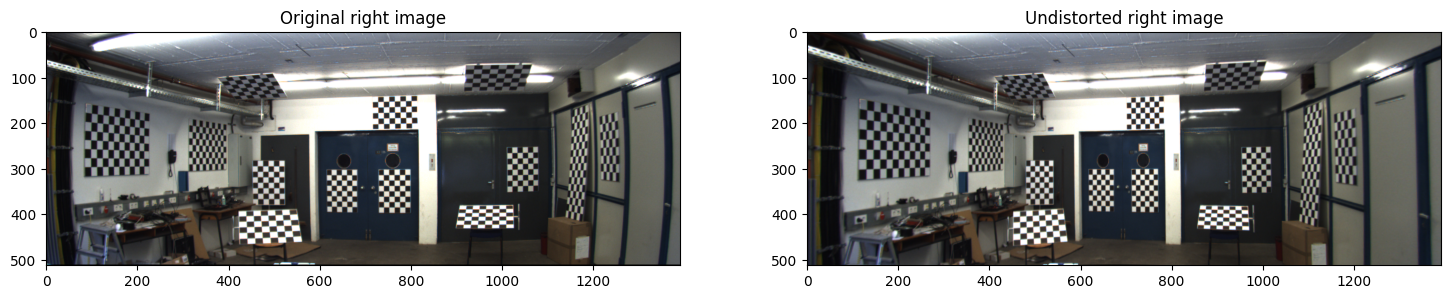

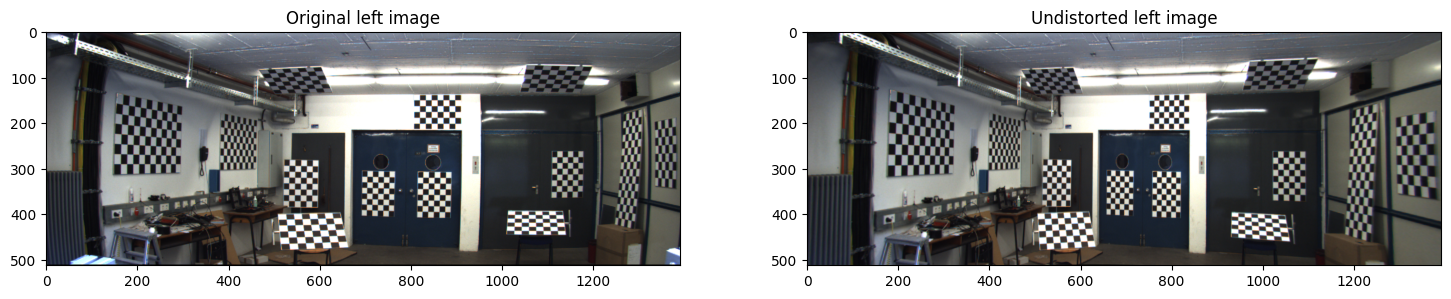

In [29]:
img = cv2.imread('calib/image_03/data/0000000000.png')
h = img.shape[0]
w = img.shape[1]

K_03_new, roi_right = cv2.getOptimalNewCameraMatrix(K_03, D_03, (w,h), 0, (w,h))

# undistort
dst1 = cv2.undistort(img, K_03, D_03, None, K_03_new)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img[...,[2,1,0]])
ax[0].set_title('Original right image')
ax[1].imshow(dst1[...,[2,1,0]])
ax[1].set_title('Undistorted right image')

img = cv2.imread('calib/image_02/data/0000000000.png')
h = img.shape[0]
w = img.shape[1]

K_02_new, roi_left = cv2.getOptimalNewCameraMatrix(K_02, D_02, (w,h), 0, (w,h))

# undistort
dst2 = cv2.undistort(img, K_02, D_02, None, K_02_new)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img[...,[2,1,0]])
ax[0].set_title('Original left image')
ax[1].imshow(dst2[...,[2,1,0]])
ax[1].set_title('Undistorted left image')




In [30]:
# Load the left and right images
img_l = cv2.imread('calib/image_02/data/0000000000.png', cv2.IMREAD_GRAYSCALE)
img_r = cv2.imread('calib/image_03/data/0000000000.png', cv2.IMREAD_GRAYSCALE)

h = img_l.shape[0]
w = img_l.shape[1]

new_left_shape = np.array(roi_left[2:]) + 1
new_right_shape = np.array(roi_right[2:]) + 1

stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +
                    cv2.TERM_CRITERIA_EPS, 100, 1e-5)

flags = (cv2.CALIB_FIX_PRINCIPAL_POINT | cv2.CALIB_FIX_ASPECT_RATIO | cv2.CALIB_FIX_FOCAL_LENGTH |
         cv2.CALIB_FIX_INTRINSIC | cv2.CALIB_FIX_K3 | cv2.CALIB_FIX_K4 | cv2.CALIB_FIX_K5 |
         cv2.CALIB_FIX_K6)

# ret_stereo, K_02, D_02, K_03, D_03, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, K_02, D_02, K_03, D_03, gray_left.shape[::-1], flags=flags, criteria=stereocalib_criteria)

# Ensure calibration parameters and rectification maps are ready
R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(K_02, D_02, K_03, D_03, new_left_shape, R, T, alpha = 0)

print(f"R1: \n{R1}")
print(f"R2: \n{R2}")
print(f"P1: \n{P1}")
print(f"P2: \n{P2}")
print(f"Q: \n{Q}")
print(f"validPixROI1 :\n{validPixROI1}")
print(f"validPixROI2 :\n{validPixROI2}")

# Compute rectification maps

map1_left, map2_left = cv2.initUndistortRectifyMap(K_02, D_02,  R1, P1, new_left_shape, cv2.CV_32FC1)
map1_right, map2_right = cv2.initUndistortRectifyMap(K_03, D_03, R2, P2, new_right_shape, cv2.CV_32FC1)

# Apply the rectification maps
rectified_left = cv2.remap(img_l, map1_left, map2_left, cv2.INTER_LINEAR)
rectified_right = cv2.remap(img_r, map1_right, map2_right, cv2.INTER_LINEAR)
print(rectified_left.shape)
# Display or save the rectified images
cv2.imwrite('rectified_left.png', rectified_left)
cv2.imwrite('rectified_right.png', rectified_right)


R1: 
[[ 0.95575189  0.04537376 -0.29065365]
 [-0.0450372   0.99895446  0.00785101]
 [ 0.29070599  0.00558661  0.95679612]]
R2: 
[[ 0.97805592  0.02222443 -0.20715377]
 [-0.02246291  0.99974696  0.00120118]
 [ 0.20712805  0.00347846  0.97830766]]
P1: 
[[1.12002925e+03 0.00000000e+00 1.13686987e+03 0.00000000e+00]
 [0.00000000e+00 1.12002925e+03 2.57212803e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
P2: 
[[ 1.12002925e+03  0.00000000e+00  1.13686987e+03 -2.08150118e+03]
 [ 0.00000000e+00  1.12002925e+03  2.57212803e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]
Q: 
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.13686987e+03]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.57212803e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.12002925e+03]
 [ 0.00000000e+00  0.00000000e+00  5.38087251e-01 -0.00000000e+00]]
validPixROI1 :
(0, 0, 1392, 511)
validPixROI2 :
(0, 0, 1392, 512)
(512, 1392)


True

In [31]:
print(R_rect_02 - R1)
print(R_rect_03 - R2)
print(P_rect_03 - P1)
print(P_rect_03 - P2)

[[ 0.04411721 -0.03024613  0.2849118 ]
 [ 0.02990859  0.00093104 -0.00797977]
 [-0.28496674 -0.005371    0.04318738]]
[[ 0.02175748 -0.02883072  0.22530551]
 [ 0.02910023  0.00022964 -0.0028512 ]
 [-0.22526847 -0.00170826  0.02152624]]
[[-4.12979948e+02  0.00000000e+00 -5.32788469e+02 -3.34108100e+02]
 [ 0.00000000e+00 -4.12979948e+02 -7.67062029e+01  2.33066000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.20115300e-03]]
[[-4.12979948e+02  0.00000000e+00 -5.32788469e+02  1.74739308e+03]
 [ 0.00000000e+00 -4.12979948e+02 -7.67062029e+01  2.33066000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.20115300e-03]]


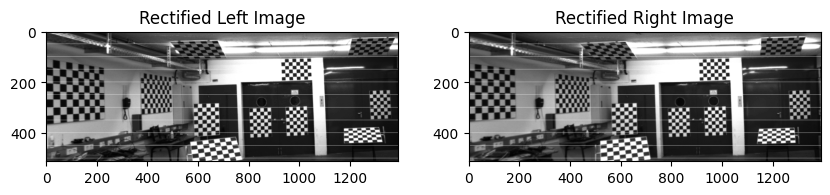

In [32]:
def draw_horizontal_lines(image, step=50):
    for y in range(0, image.shape[0], step):
        cv2.line(image, (0, y), (image.shape[1], y), (255, 255, 255), 1)
    return image

left_with_lines = draw_horizontal_lines(rectified_left.copy())
right_with_lines = draw_horizontal_lines(rectified_right.copy())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Rectified Left Image")
plt.imshow(left_with_lines, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Rectified Right Image")
plt.imshow(right_with_lines, cmap='gray')
plt.show()
